
The feature selection notebook does a filter followed by a wrapper. It's capable of doing the filter on more than one file. The variable files are called vars1.csv, vars2.csv ...

The filter runs separately on each vars file and keeps the top num_filter variables from each file. If there are more than one vars files we'll again select the top num_filter variables across all the vars.csv files.

If balance = 0 the entire files are used. If balance != 0 then balance is the ratio of goods to bads retained for the rest of the feature selection. We keep all the rare class (bads) and downsample the goods. 

In [1]:
# load libraries
# %pip install mlxtend
# %pip install lightgbm

import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import datetime as dt
import gc
from sklearn.ensemble import RandomForestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from lightgbm import LGBMClassifier
import re
%matplotlib inline
start_time = dt.datetime.now()

In [2]:
# set some parameters
num_files = 1
num_filter = 80
num_wrapper = 20
balance = 0
detect_rate = .03
index_name = 'Recnum'
y_name = 'Fraud'
# index_name = 'record'
# y_name = 'fraud_label'
good_label = 0
bad_label = 1

## Run a filter on all the files

In [14]:
data = pd.read_csv('vars.csv')
data.columns

Index(['Unnamed: 0', 'Recnum', 'Cardnum', 'Date', 'Merchnum',
       'Merch description', 'Merch state', 'Merch zip', 'Transtype', 'Amount',
       ...
       'max_count_by_Cardnum_Merchzip5_14',
       'max_count_by_Cardnum_Merchzip5_30',
       'max_count_by_Cardnum_Merchzip5_90', 'max_count_by_Cardnum_Merchzip3_3',
       'max_count_by_Cardnum_Merchzip3_7', 'max_count_by_Cardnum_Merchzip3_14',
       'max_count_by_Cardnum_Merchzip3_30',
       'max_count_by_Cardnum_Merchzip3_90', 'Cardnum_U*', 'Merchnum_U*'],
      dtype='object', length=994)

In [15]:
col=pd.Series(data.columns)

In [18]:
droplist=[]
for i in col:
    if re.findall(r'\b\w+(?:\s)?\w+_max\w+\b', i):
        for j in re.findall(r'\b\w+(?:\s)?\w+_max\w+\b', i):
            droplist.append(j)
droplist

['Cardnum_max_0',
 'Cardnum_max_1',
 'Cardnum_max_3',
 'Cardnum_max_7',
 'Cardnum_max_14',
 'Cardnum_max_30',
 'Cardnum_max_90',
 'Merchnum_max_0',
 'Merchnum_max_1',
 'Merchnum_max_3',
 'Merchnum_max_7',
 'Merchnum_max_14',
 'Merchnum_max_30',
 'Merchnum_max_90',
 'Merch description_max_0',
 'Merch description_max_1',
 'Merch description_max_3',
 'Merch description_max_7',
 'Merch description_max_14',
 'Merch description_max_30',
 'Merch description_max_90',
 'Merch zip_max_0',
 'Merch zip_max_1',
 'Merch zip_max_3',
 'Merch zip_max_7',
 'Merch zip_max_14',
 'Merch zip_max_30',
 'Merch zip_max_90',
 'Merch zip3_max_0',
 'Merch zip3_max_1',
 'Merch zip3_max_3',
 'Merch zip3_max_7',
 'Merch zip3_max_14',
 'Merch zip3_max_30',
 'Merch zip3_max_90',
 'Cardnum_Merchnum_max_0',
 'Cardnum_Merchnum_max_1',
 'Cardnum_Merchnum_max_3',
 'Cardnum_Merchnum_max_7',
 'Cardnum_Merchnum_max_14',
 'Cardnum_Merchnum_max_30',
 'Cardnum_Merchnum_max_90',
 'Cardnum_Merchdesc_max_0',
 'Cardnum_Merchdesc_max

In [19]:
df=data.drop(droplist, axis = 1)
df.columns

Index(['Unnamed: 0', 'Recnum', 'Cardnum', 'Date', 'Merchnum',
       'Merch description', 'Merch state', 'Merch zip', 'Transtype', 'Amount',
       ...
       'max_count_by_Cardnum_Merchzip5_14',
       'max_count_by_Cardnum_Merchzip5_30',
       'max_count_by_Cardnum_Merchzip5_90', 'max_count_by_Cardnum_Merchzip3_3',
       'max_count_by_Cardnum_Merchzip3_7', 'max_count_by_Cardnum_Merchzip3_14',
       'max_count_by_Cardnum_Merchzip3_30',
       'max_count_by_Cardnum_Merchzip3_90', 'Cardnum_U*', 'Merchnum_U*'],
      dtype='object', length=931)

In [20]:
%%time

df = df.set_index(index_name) 
df = df[df.index <= 84300] # remove the last two months as the out-of-time data (OOT)
df = df[df.index >= 2995] # remove the first 2 weeks of records since their variables aren't well formed
df['RANDOM'] = np.random.ranf(len(df)) # add a random number variable to make sure it doesn't come up as important
goods = df[df[y_name] == good_label]
bads = df[df[y_name] == bad_label]
num_vars = len(bads.columns)-2

filter_score = pd.DataFrame(np.zeros((num_vars+1,2)))
filter_score.columns = ['variable','score']   
j = 0
for column in df:
    filter_score.loc[j,'variable'] = column
    filter_score.loc[j,'score'] = sps.ks_2samp(goods[column],bads[column])[0]
    j = j+1

filter_score.sort_values(by=['score'], ascending=False, inplace=True)
vars_keep = list(filter_score['variable'][1:num_filter+1]) 
Y = pd.DataFrame(df[y_name], index=df.index)
df_top = df.filter(vars_keep, axis=1)
    
del goods # delete these before starting the next file, if any
del bads
gc.collect()

CPU times: user 17.9 s, sys: 2.66 s, total: 20.5 s
Wall time: 23.2 s


1317

In [21]:
filter_score.head(30)

variable     score
9                         Fraud  1.000000
698   Cardnum_Merchzip3_total_7  0.695635
687   Cardnum_Merchzip3_total_3  0.687836
619   Cardnum_Merchzip5_total_7  0.684517
709  Cardnum_Merchzip3_total_14  0.681686
461    Cardnum_Merchnum_total_7  0.681017
608   Cardnum_Merchzip5_total_3  0.677563
450    Cardnum_Merchnum_total_3  0.675054
472   Cardnum_Merchnum_total_14  0.674867
630  Cardnum_Merchzip5_total_14  0.671828
540   Cardnum_Merchdesc_total_7  0.671267
676   Cardnum_Merchzip3_total_1  0.666318
551  Cardnum_Merchdesc_total_14  0.665538
529   Cardnum_Merchdesc_total_3  0.661331
720  Cardnum_Merchzip3_total_30  0.660771
597   Cardnum_Merchzip5_total_1  0.660539
483   Cardnum_Merchnum_total_30  0.658264
439    Cardnum_Merchnum_total_1  0.658215
562  Cardnum_Merchdesc_total_30  0.656843
641  Cardnum_Merchzip5_total_30  0.656306
573  Cardnum_Merchdesc_total_90  0.639734
518   Cardnum_Merchdesc_total_1  0.638277
494   Cardnum_Merchnum_total_90  0.638250
731  Cardnum_Merchzip3_total_90  0.637888
652  Cardnum_Merchzip5_total_90  0.636634
213   Merch description_total_3  0.624884
665   Cardnum_Merchzip3_total_0  0.615347
202   Merch description_total_1  0.611661
428    Cardnum_Merchnum_total_0  0.611190
507   Cardnum_Merchdesc_total_0  0.609989

In [22]:
filter_score.tail(10)

variable     score
791          Merch zip_count_0_by_30  0.070888
827    Cardnum_Merchnum_count_1_by_7  0.069777
877  Cardnum_Merchzip3_count_1_by_14  0.068355
829   Cardnum_Merchnum_count_1_by_14  0.060124
859   Cardnum_Merchzip5_count_1_by_7  0.055219
803          Merch zip3_count_0_by_7  0.049358
825   Cardnum_Merchnum_count_0_by_90  0.045962
930                           RANDOM  0.031843
13                        state_risk  0.000000
7                          Transtype  0.000000

In [23]:
filter_score.shape

(931, 2)

In [24]:
vars_keep

['Cardnum_Merchzip3_total_7',
 'Cardnum_Merchzip3_total_3',
 'Cardnum_Merchzip5_total_7',
 'Cardnum_Merchzip3_total_14',
 'Cardnum_Merchnum_total_7',
 'Cardnum_Merchzip5_total_3',
 'Cardnum_Merchnum_total_3',
 'Cardnum_Merchnum_total_14',
 'Cardnum_Merchzip5_total_14',
 'Cardnum_Merchdesc_total_7',
 'Cardnum_Merchzip3_total_1',
 'Cardnum_Merchdesc_total_14',
 'Cardnum_Merchdesc_total_3',
 'Cardnum_Merchzip3_total_30',
 'Cardnum_Merchzip5_total_1',
 'Cardnum_Merchnum_total_30',
 'Cardnum_Merchnum_total_1',
 'Cardnum_Merchdesc_total_30',
 'Cardnum_Merchzip5_total_30',
 'Cardnum_Merchdesc_total_90',
 'Cardnum_Merchdesc_total_1',
 'Cardnum_Merchnum_total_90',
 'Cardnum_Merchzip3_total_90',
 'Cardnum_Merchzip5_total_90',
 'Merch description_total_3',
 'Cardnum_Merchzip3_total_0',
 'Merch description_total_1',
 'Cardnum_Merchnum_total_0',
 'Cardnum_Merchdesc_total_0',
 'Cardnum_Merchzip5_total_0',
 'Cardnum_total_3',
 'Cardnum_Merchzip5_avg_30',
 'Merch zip_total_3',
 'Cardnum_total_7',
 'Me

In [25]:
df_top.head()

Cardnum_Merchzip3_total_7  Cardnum_Merchzip3_total_3  \
Recnum                                                         
2995                      1023.04                     174.20   
2996                       250.00                     250.00   
2997                        76.85                      76.85   
2998                      1269.00                    1269.00   
2999                       288.38                     288.38   

        Cardnum_Merchzip5_total_7  Cardnum_Merchzip3_total_14  \
Recnum                                                          
2995                      1023.04                     1023.04   
2996                       250.00                      250.00   
2997                        76.85                       76.85   
2998                      1269.00                     1269.00   
2999                       288.38                      288.38   

        Cardnum_Merchnum_total_7  Cardnum_Merchzip5_total_3  \
Recnum                                                        
2995                     1023.04                     174.20   
2996                      250.00                     250.00   
2997                       76.85                      76.85   
2998                     1269.00                    1269.00   
2999                      288.38                     288.38   

        Cardnum_Merchnum_total_3  Cardnum_Merchnum_total_14  \
Recnum                                                        
2995                      174.20                    1023.04   
2996                      250.00                     250.00   
2997                       76.85                      76.85   
2998                     1269.00                    1269.00   
2999                      288.38                     288.38   

        Cardnum_Merchzip5_total_14  Cardnum_Merchdesc_total_7  ...  \
Recnum                                                         ...   
2995                       1023.04                    1023.04  ...   
2996                        250.00                     250.00  ...   
2997                         76.85                      76.85  ...   
2998                       1269.00                    1269.00  ...   
2999                        288.38                     288.38  ...   

        Cardnum_Merchzip5_avg_0  Merchnum_avg_1  Cardnum_avg_1  \
Recnum                                                           
2995                     174.20        174.2000     346.280000   
2996                     250.00        250.0000     389.285714   
2997                      53.88        223.3100      53.880000   
2998                    1269.00        370.3375     653.900000   
2999                     288.38        396.5600     288.380000   

        Cardnum_total_0  Cardnum_Merchnum_med_30  Cardnum_avg_0  \
Recnum                                                            
2995             174.20                  174.200         174.20   
2996             250.00                  250.000         250.00   
2997              53.88                   38.425          53.88   
2998            1269.00                 1269.000        1269.00   
2999             288.38                  288.380         288.38   

        Cardnum_avg_3  Merch description_avg_1  Merchnum_total_0  \
Recnum                                                             
2995       229.921111                 174.2000            174.20   
2996       389.285714                 250.0000            250.00   
2997        38.425000                 223.3100             53.88   
2998       404.265000                 370.3375           1269.00   
2999       368.093333                 396.5600            288.38   

        Cardnum_Merchzip5_med_3  
Recnum                           
2995                    174.200  
2996                    250.000  
2997                     38.425  
2998                   1269.000  
2999                    288.380  

[5 rows x 80 columns]

In [26]:
df_top.shape

(80983, 80)

In [27]:
Y.head()

Fraud
Recnum       
2995        0
2996        0
2997        0
2998        0
2999        0

In [28]:
Y = Y.values
Y_save = Y.copy()

In [29]:
# Y = np.array(Y)
X = df_top
print(Y)

[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


In [30]:
print(X.shape,Y.shape)

(80983, 80) (80983, 1)


In [31]:
print(type(X),type(Y))

<class 'pandas.core.frame.DataFrame'> <class 'numpy.ndarray'>


In [32]:
# I'd like to define a scoring for the wrapper that's KS, but I haven't gotten around to this yet.
# def KSscore(classifier, x,y)
#     goods = 

In [33]:
def fdr(classifier, x, y, cutoff=detect_rate):
# Calculates FDR score for the given classifier on dataset x and y with cutoff value
# get the probability list from the given classifier
    return fdr_prob(y, classifier.predict_proba(x), cutoff)
def fdr_prob(y, y_prob, cutoff=detect_rate):
    if len(y_prob.shape) != 1:    # sometimes the proba list can contain many columns, one for each category
        y_prob = y_prob[:, -1:]   # only the last one (fraud_label==1) is used here.
    num_fraud = len(y[y == 1])    # count the total nunber of frauds   
# sort the proba list from high to low while retain the true (not predicted) fraud label
    sorted_prob = np.asarray(sorted(zip(y_prob, y), key=lambda x: x[0], reverse=True))
    cutoff_bin = sorted_prob[0:int(len(y) * cutoff), 1:]  # 3% cutoff
# return the FDR score (#fraud_in_cutoff / #total_fraud)
    return len(cutoff_bin[cutoff_bin == 1]) / num_fraud   

In [34]:
%%time
import warnings 
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
# If you're doing forward selection it's enough to stop at num_wrapper variables. 
# If you're doing backward selection you need to go through all the variables to get 
# a sorted list of num_wrapper variables.
nfeatures = len(X.columns)
# clf = RandomForestClassifier(n_estimators=5) # simple, fast nonlinear model for the wrapper
clf = LGBMClassifier(n_estimators=30,num_leaves=3) # simple, fast nonlinear model for the wrapper
sfs = SFS(clf,k_features=num_wrapper,forward=True,verbose=2,scoring=fdr,cv=10,n_jobs=-1) # forward selection
# sfs = SFS(clf,k_features=1,forward=False,verbose=2,scoring=fdr,cv=2,n_jobs=-1) # backward selection
sfs.fit(X,Y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/prep

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   46.8s
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.6min finished

[2022-04-17 20:32:25] Features: 1/20 -- score: 0.6223202352312216[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   41.7s
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  79 out of  79 | elapsed:  1.6min finished

[2022-04-17 20:34:02] Features: 2/20 -- score: 0.6613472333600642[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   37.6s
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  78 out of  78 | elapsed:  1.4min finished

[2022-04-17 20:35:28] Features: 3/20 -- score: 0.6625902165196471[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  77 out of  77 | elapsed:  2.3min finished

[2022-04-17 20:37:44] Features: 4/20 -- score: 0.6833333333333333[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  76 out of  76 | elapsed:  2.5min finished

[2022-04-17 20:40:14] Features: 5/20 -- score: 0.6902833466987436[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  75 out of  75 | elapsed:  2.0min finished

[2022-04-17 20:42:16] Features: 6/20 -- score: 0.6983025928896017[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  74 out of  74 | elapsed:  2.4min finished

[2022-04-17 20:44:42] Features: 7/20 -- score: 0.699452018176958[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  73 out of  73 | elapsed:  3.2min finished

[2022-04-17 20:47:52] Features: 8/20 -- score: 0.7006014434643143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   57.3s
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  2.1min finished

[2022-04-17 20:49:58] Features: 9/20 -- score: 0.7006014434643143[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  71 out of  71 | elapsed:  2.5min finished

[2022-04-17 20:52:28] Features: 10/20 -- score: 0.699452018176958[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sample

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:  2.7min finished

[2022-04-17 20:55:07] Features: 11/20 -- score: 0.7006014434643144[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  69 out of  69 | elapsed:  2.5min finished

[2022-04-17 20:57:34] Features: 12/20 -- score: 0.7006014434643144[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.1min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  68 out of  68 | elapsed:  2.3min finished

[2022-04-17 20:59:49] Features: 13/20 -- score: 0.699452018176958[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.3min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:  2.4min finished

[2022-04-17 21:02:11] Features: 14/20 -- score: 0.699452018176958[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.4min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  66 out of  66 | elapsed:  2.7min finished

[2022-04-17 21:04:56] Features: 15/20 -- score: 0.699452018176958[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.9min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  65 out of  65 | elapsed:  3.4min finished

[2022-04-17 21:08:17] Features: 16/20 -- score: 0.699452018176958[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  64 out of  64 | elapsed:  3.1min finished

[2022-04-17 21:11:24] Features: 17/20 -- score: 0.6971130713712911[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.8min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed:  3.4min finished

[2022-04-17 21:14:49] Features: 18/20 -- score: 0.7006014434643144[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samp

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.6min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_la

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  62 out of  62 | elapsed:  3.1min finished

[2022-04-17 21:17:56] Features: 19/20 -- score: 0.7006148088746325[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_sampl

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.4min
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_lab

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed

/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/yuqizhang/opt/anaconda3/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed

[Parallel(n_jobs=-1)]: Done  61 out of  61 | elapsed:  3.8min finished

[2022-04-17 21:21:46] Features: 20/20 -- score: 0.7006148088746325

CPU times: user 17.6 s, sys: 12.4 s, total: 30 s
Wall time: 50min 59s


SequentialFeatureSelector(cv=10,
                          estimator=LGBMClassifier(n_estimators=30,
                                                   num_leaves=3),
                          k_features=20, n_jobs=-1,
                          scoring=<function fdr at 0x7ff073a75d30>, verbose=2)

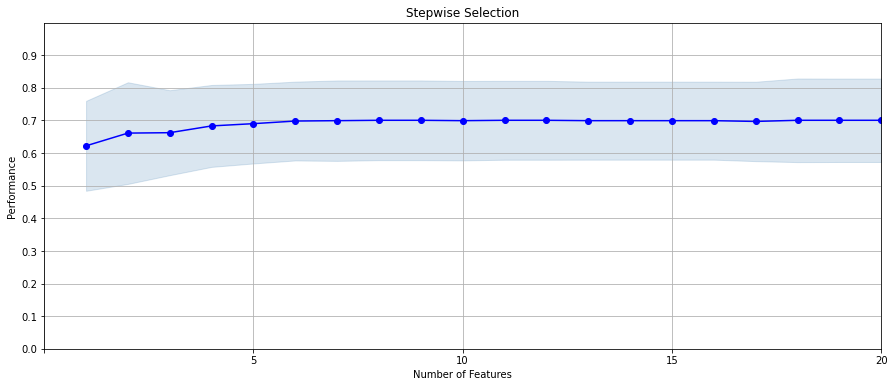

In [35]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
fig1 = plot_sfs(sfs.get_metric_dict(),kind='std_dev', figsize=(15, 6))
plt.xticks(np.arange(0, len(X.columns), step=5))
plt.yticks(np.arange(0,1,step=.1))
plt.ylim([0., 1])
plt.xlim(0,num_wrapper)
plt.title('Stepwise Selection')
plt.grid()
plt.savefig('FS_fdr.png')
plt.show()

In [36]:
vars_FS = pd.DataFrame.from_dict(sfs.get_metric_dict()).T

In [37]:
ordered_vars_FS = vars_FS.copy()
for i in range(len(ordered_vars_FS)):
    ordered_vars_FS.loc[i+1,'add variables in this order'] = int(i+1)
    if i+1 == 1:
        ordered_vars_FS.loc[i+1,'variable name'] = list(ordered_vars_FS.loc[i+1,'feature_names'])[0]
    else:
        ordered_vars_FS.loc[i+1,'variable name'] = set(ordered_vars_FS.loc[i+1,'feature_names']) - set(ordered_vars_FS.loc[i,'feature_names'])

In [38]:
ordered_vars_FS

feature_idx  \
1                                                (0,)   
2                                             (0, 41)   
3                                         (0, 41, 69)   
4                                     (0, 11, 41, 69)   
5                                 (0, 11, 35, 41, 69)   
6                             (0, 11, 35, 41, 69, 70)   
7                         (0, 11, 35, 41, 69, 70, 77)   
8                     (0, 11, 23, 35, 41, 69, 70, 77)   
9                 (0, 11, 19, 23, 35, 41, 69, 70, 77)   
10            (0, 11, 19, 23, 35, 39, 41, 69, 70, 77)   
11        (0, 11, 19, 23, 35, 39, 40, 41, 69, 70, 77)   
12    (0, 11, 19, 21, 23, 35, 39, 40, 41, 69, 70, 77)   
13  (0, 11, 19, 21, 23, 35, 39, 40, 41, 42, 69, 70...   
14  (0, 11, 19, 21, 23, 35, 36, 39, 40, 41, 42, 69...   
15  (0, 11, 19, 21, 23, 35, 36, 39, 40, 41, 42, 43...   
16  (0, 11, 19, 21, 23, 35, 36, 39, 40, 41, 42, 43...   
17  (0, 11, 19, 21, 23, 35, 36, 39, 40, 41, 42, 43...   
18  (0, 11, 19, 21, 23, 35, 36, 39, 40, 41, 42, 43...   
19  (0, 11, 19, 21, 23, 31, 35, 36, 39, 40, 41, 42...   
20  (0, 11, 19, 21, 23, 31, 35, 36, 38, 39, 40, 41...   

                                            cv_scores avg_score  \
1   [0.42528735632183906, 0.6091954022988506, 0.74...   0.62232   
2   [0.5172413793103449, 0.6666666666666666, 0.885...  0.661347   
3   [0.5172413793103449, 0.6781609195402298, 0.712...   0.66259   
4   [0.6206896551724138, 0.6896551724137931, 0.839...  0.683333   
5   [0.6206896551724138, 0.6781609195402298, 0.850...  0.690283   
6   [0.7241379310344828, 0.6781609195402298, 0.850...  0.698303   
7   [0.7471264367816092, 0.6896551724137931, 0.850...  0.699452   
8   [0.7471264367816092, 0.6896551724137931, 0.850...  0.700601   
9   [0.7471264367816092, 0.6896551724137931, 0.850...  0.700601   
10  [0.735632183908046, 0.6896551724137931, 0.8505...  0.699452   
11  [0.735632183908046, 0.6896551724137931, 0.8505...  0.700601   
12  [0.735632183908046, 0.6896551724137931, 0.8505...  0.700601   
13  [0.735632183908046, 0.6896551724137931, 0.8390...  0.699452   
14  [0.735632183908046, 0.6896551724137931, 0.8390...  0.699452   
15  [0.735632183908046, 0.6896551724137931, 0.8390...  0.699452   
16  [0.735632183908046, 0.6896551724137931, 0.8390...  0.699452   
17  [0.7471264367816092, 0.6896551724137931, 0.839...  0.697113   
18  [0.7701149425287356, 0.6896551724137931, 0.839...  0.700601   
19  [0.7586206896551724, 0.6896551724137931, 0.839...  0.700615   
20  [0.7586206896551724, 0.6896551724137931, 0.839...  0.700615   

                                        feature_names  ci_bound   std_dev  \
1                        (Cardnum_Merchzip3_total_7,)  0.102388  0.137857   
2   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.115713  0.155797   
3   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...   0.09673  0.130238   
4   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.093266  0.125574   
5   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.090622  0.122015   
6   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.089732  0.120817   
7   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.091557  0.123274   
8   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.090726  0.122154   
9   (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.090726  0.122154   
10  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.090436  0.121764   
11  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.089838  0.120959   
12  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.089838  0.120959   
13  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...   0.08881  0.119575   
14  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...   0.08881  0.119575   
15  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...   0.08881  0.119575   
16  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...   0.08881  0.119575   
17  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_...  0.090386  0.121697   
18  (Cardnum_Merchzip3_total_7, Cardnum_Merchdesc_

In [39]:
ordered_vars_FS.to_csv('VarsFS.csv', index=False)

In [40]:
ordered_vars_FS['variable name']

1      Cardnum_Merchzip3_total_7
2       Cardnum_Merchdesc_avg_90
3       Merch zip3_actual-avg_90
4     Cardnum_Merchdesc_total_14
5       Cardnum_Merchdesc_avg_30
6        Cardnum_Merchzip5_avg_0
7        Merch description_avg_1
8     Cardnum_Merchzip5_total_90
9     Cardnum_Merchdesc_total_90
10       Cardnum_Merchzip5_avg_7
11       Cardnum_Merchzip3_avg_3
12     Cardnum_Merchnum_total_90
13      Cardnum_Merchdesc_avg_14
14      Cardnum_Merchzip5_avg_14
15       Cardnum_Merchzip5_avg_3
16       Cardnum_Merchnum_avg_14
17       Cardnum_Merchzip5_avg_1
18                Merchnum_avg_1
19      Cardnum_Merchzip5_avg_30
20       Cardnum_Merchnum_avg_30
Name: variable name, dtype: object

In [41]:
vars_keep = ordered_vars_FS['variable name']
vars_keep_list = ordered_vars_FS['variable name'].tolist()
vars_keep.to_csv('final_vars_list.csv',index=False)

In [42]:
vars_keep

1      Cardnum_Merchzip3_total_7
2       Cardnum_Merchdesc_avg_90
3       Merch zip3_actual-avg_90
4     Cardnum_Merchdesc_total_14
5       Cardnum_Merchdesc_avg_30
6        Cardnum_Merchzip5_avg_0
7        Merch description_avg_1
8     Cardnum_Merchzip5_total_90
9     Cardnum_Merchdesc_total_90
10       Cardnum_Merchzip5_avg_7
11       Cardnum_Merchzip3_avg_3
12     Cardnum_Merchnum_total_90
13      Cardnum_Merchdesc_avg_14
14      Cardnum_Merchzip5_avg_14
15       Cardnum_Merchzip5_avg_3
16       Cardnum_Merchnum_avg_14
17       Cardnum_Merchzip5_avg_1
18                Merchnum_avg_1
19      Cardnum_Merchzip5_avg_30
20       Cardnum_Merchnum_avg_30
Name: variable name, dtype: object

In [43]:
vars_keep_list.append(index_name)
vars_keep_list.append(y_name)
vars_keep_list

['Cardnum_Merchzip3_total_7',
 'Cardnum_Merchdesc_avg_90',
 'Merch zip3_actual-avg_90',
 'Cardnum_Merchdesc_total_14',
 'Cardnum_Merchdesc_avg_30',
 'Cardnum_Merchzip5_avg_0',
 'Merch description_avg_1',
 'Cardnum_Merchzip5_total_90',
 'Cardnum_Merchdesc_total_90',
 'Cardnum_Merchzip5_avg_7',
 'Cardnum_Merchzip3_avg_3',
 'Cardnum_Merchnum_total_90',
 'Cardnum_Merchdesc_avg_14',
 'Cardnum_Merchzip5_avg_14',
 'Cardnum_Merchzip5_avg_3',
 'Cardnum_Merchnum_avg_14',
 'Cardnum_Merchzip5_avg_1',
 'Merchnum_avg_1',
 'Cardnum_Merchzip5_avg_30',
 'Cardnum_Merchnum_avg_30',
 'Recnum',
 'Fraud']

In [45]:
df = pd.read_csv('vars.csv')

In [33]:
df_keep = df.filter(vars_keep_list, axis=1)
print(df_keep.shape)

(96397, 22)


In [34]:
df_keep.to_csv('vars_final.csv',index=False)

In [35]:
print('time to here:', dt.datetime.now() - start_time)

time to here: 10:03:57.535548
